In [ ]:
import torch
import transformers
import sentence_transformers

In [ ]:
pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import kagglehub
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from keybert import KeyBERT
import warnings
warnings.filterwarnings('ignore')
from sentence_transformers import SentenceTransformer

In [ ]:
pip install nltk

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
df = pd.read_csv(os.path.join(path, "Reviews.csv"))
df_new= df.sample(frac=0.03, random_state=42)
print(df.shape, df_new.shape)
df.head(3)

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.
(568454, 10) (17054, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
from nltk import pos_tag

def preprocess_text(text):

    if not isinstance(text, str) or text.strip() == '':
        return ''

    # html
    text = re.sub(r'<[^>]+>', '', text)

    # url
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # emaik
    text = re.sub(r'\S+@\S+', '', text)

    # смайлики
    text = re.sub(r'[:;=8xX>][\-o\*\']?[\)\]\(\[dDpP/\\:\}\{@\|]', '', text)
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # эмодзи

    # цифры и знаки препинания
    text = re.sub(r'[^a-zA-Z\s\']', ' ', text)

    # апострофы в словах
    text = re.sub(r"n't\b", " not", text)
    text = re.sub(r"'re\b", " are", text)
    text = re.sub(r"'s\b", " is", text)
    text = re.sub(r"'d\b", " would", text)
    text = re.sub(r"'ll\b", " will", text)
    text = re.sub(r"'t\b", " not", text)
    text = re.sub(r"'ve\b", " have", text)
    text = re.sub(r"'m\b", " am", text)

    # разделение слипшихся слов
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    text = text.lower()

    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()

    # еще стоп слова
    extended_stopwords = set(stopwords.words('english')).union({
        'would', 'could', 'should', 'may', 'might', 'must', 'shall',
        'also', 'get', 'got', 'getting', 'go', 'going', 'went', 'gone',
        'take', 'took', 'taking', 'make', 'made', 'making', 'come', 'came',
        'see', 'saw', 'seeing', 'look', 'looked', 'looking', 'know', 'knew',
        'think', 'thought', 'thinking', 'say', 'said', 'saying', 'like',
        'want', 'wanted', 'need', 'needed', 'use', 'used', 'using', 'one',
        'two', 'three', 'first', 'last', 'new', 'old', 'good', 'bad', 'nice',
        'great', 'better', 'best', 'worst', 'big', 'small', 'large', 'little',
        'really', 'very', 'quite', 'pretty', 'actually', 'probably', 'maybe',
        'perhaps', 'literally', 'basically', 'definitely', 'absolutely',
        'thing', 'things', 'stuff', 'item', 'items', 'product', 'products',
        'buy', 'bought', 'buying', 'purchase', 'purchased', 'order', 'ordered',
        'price', 'cost', 'money', 'cheap', 'expensive', 'quality', 'service',
        'shipping', 'delivery', 'time', 'year', 'month', 'week', 'day', 'today',
        'yesterday', 'tomorrow', 'now', 'then', 'always', 'never', 'sometimes',
        'often', 'usually'
    })

    # pos-тегирование
    pos_tags = pos_tag(tokens)

    # лемматизация
    lemmatizer = WordNetLemmatizer()
    processed_tokens = []

    for word, pos in pos_tags:
        if word in extended_stopwords or len(word) < 3 or len(word) > 25:
            continue

        if pos.startswith('V'):  # глаголы
            lemma = lemmatizer.lemmatize(word, pos='v')
        elif pos.startswith('J'):  # прилагательные
            lemma = lemmatizer.lemmatize(word, pos='a')
        elif pos.startswith('R'):  # наречия
            lemma = lemmatizer.lemmatize(word, pos='r')
        else:  # остальное
            lemma = lemmatizer.lemmatize(word, pos='n')

        # Дополнительная фильтрация
        if (lemma.isalpha() and
            len(lemma) >= 3 and
            len(lemma) <= 25 and
            lemma not in extended_stopwords):

            processed_tokens.append(lemma)

    unique_tokens = list(set(processed_tokens))

    processed_text = ' '.join(unique_tokens)

    return processed_text

df_new['processed_text'] = df_new['Text'].apply(preprocess_text)

print('До обработки')
print(df_new['Text'].head(3))
print('\nПосле обработки')
print(df_new['processed_text'].head(3))

До обработки
165256    Having tried a couple of other brands of glute...
231465    My cat loves these treats. If ever I can't fin...
427827    A little less than I expected.  It tends to ha...
Name: Text, dtype: object

После обработки
165256    glutino texture sandwich satisfy tooth brand f...
231465    flavor dry kitty yet equally lid handy find tr...
427827    favorite less since eected tend muddy company ...
Name: processed_text, dtype: object


In [ ]:
import torch
torch.cuda.is_available()

True

# Метрики кластеризации
## Силуэтный коэффициент:
метрика помогает нам понять, насколько хорошо сгруппированы точки данных. Показатель варьируется от -1 до 1.
- Оценка, близкая к 1, означает, что точка очень хорошо вписывается в свою кластер и далека от других кластеров.
- Оценка, близкая к 0, означает, что точка находится на границе между двумя кластерами.
- Оценка, близкая к -1, означает, что точка может находиться не в том кластере.
## Индекс Калински-Харабаша:
учитывает:
1. насколько близко друг к другу расположены точки внутри каждого кластера?
2. насколько далеко друг от друга расположены кластеры?
- Чем выше балл, тем лучше, так как это означает, что кластеры плотные и хорошо разделены. Это помогает определить идеальное количество кластеров.
## Индекс Дэвиса-Болдуина:
- показывает, насколько плотно сгруппированы кластеры (компактность) и насколько они удалены друг от друга (разделение).

Чем **выше** DBI, тем больше беспорядка, кластеры накладываются друг на друга

Чем **ниже** балл, тем лучше, потому что это означает:
1. Точки в одном кластере расположены близко друг к другу.
2. Разные кластеры находятся далеко друг от друга.


In [ ]:
# Метрики
def evaluate_clustering(vectors, clusters, method_name):
    print(f"Метрики для {method_name} ---")
    print(f"Количество кластеров: {len(set(clusters))}")

    if len(set(clusters)) > 1:
        silhouette = silhouette_score(vectors, clusters)
        calinski_harabasz = calinski_harabasz_score(vectors, clusters)
        davies_bouldin = davies_bouldin_score(vectors, clusters)

        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
        print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

        return silhouette, calinski_harabasz, davies_bouldin
    else:
        print("Недостаточно кластеров для вычисления метрик")
        return None, None, None

In [ ]:
# SBERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_vectors = sbert_model.encode(df_new['processed_text'].tolist(), show_progress_bar=True, batch_size=128, normalize_embeddings=True)
print(f"SBERT: Создано {sbert_vectors.shape[0]} документов с {sbert_vectors.shape[1]} измерениями")

from umap import UMAP
umap_sbert = UMAP(
    n_components=15,
    random_state=42,
    metric='cosine',
    n_neighbors=50,
    min_dist=0.05,
    spread=1.5,
    n_epochs=1000
)
sbert_vectors_umap = umap_sbert.fit_transform(sbert_vectors)

# KMeans с подбором оптимального количества кластеров для SBERT
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Создаем подвыборку
sample_size = min(1000, len(sbert_vectors_umap))
sample_indices = np.random.choice(len(sbert_vectors_umap), sample_size, replace=False)
sbert_sample = sbert_vectors_umap[sample_indices]

best_score = -1
best_n_clusters = 0


for n_clusters in range(2, 10):
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10
    )
    clusters = kmeans.fit_predict(sbert_sample)
    score = silhouette_score(sbert_sample, clusters)

    print(f"Кластеры: {n_clusters}, Силуэт: {score:.3f}")

    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"\nЛучшее количество кластеров: {best_n_clusters}")
print(f"Лучший силуэт: {best_score:.3f}")

kmeans_final = KMeans(
    n_clusters=best_n_clusters,
    random_state=42,
    n_init=20
)
sbert_clusters = kmeans_final.fit_predict(sbert_vectors_umap)

df_new['SBERT_Cluster'] = sbert_clusters
hdb2_metrics = evaluate_clustering(sbert_vectors_umap, sbert_clusters, "SBERT кластеризации")

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

SBERT: Создано 17054 документов с 384 измерениями
Кластеры: 2, Силуэт: 0.401
Кластеры: 3, Силуэт: 0.477
Кластеры: 4, Силуэт: 0.433
Кластеры: 5, Силуэт: 0.422
Кластеры: 6, Силуэт: 0.439
Кластеры: 7, Силуэт: 0.420
Кластеры: 8, Силуэт: 0.436
Кластеры: 9, Силуэт: 0.421

Лучшее количество кластеров: 3
Лучший силуэт: 0.477
Метрики для SBERT кластеризации ---
Количество кластеров: 3
Silhouette Score: 0.472
Calinski-Harabasz Index: 19226.410
Davies-Bouldin Index: 0.765


# SBERT кластеризация (3 кластера)
- Silhouette Score: 0.47 неплохое разбиение. Кластеры имеют четкие границы и хорошую внутреннюю связность
- Calinski-Harabasz Index: 19226. Высокое качество разбиения. Кластеры компактные и далеко отстоят друг от друга
- Davies-Bouldin Index: 0.765 - хорошо. Чем ниже значение, тем лучше (идеал стремится к 0), показатель, указывающий на минимальное перекрытие кластеров

In [ ]:
# Векторизация TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=2500,
    min_df=10,
    max_df=0.6,
    use_idf=True,
    norm='l2',
    stop_words='english',
    sublinear_tf=True

)
tfidf_vectors = tfidf_vectorizer.fit_transform(df_new['processed_text']).toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"TF-IDF: Создано {tfidf_vectors.shape[0]} документов с {tfidf_vectors.shape[1]} признаками")

from umap import UMAP
umap_tfidf = UMAP(
    n_components=7,
    random_state=42,
    metric='cosine',
    n_neighbors=70,
    min_dist=0.05,
    spread=1.5
)
tfidf_vectors_umap = umap_tfidf.fit_transform(tfidf_vectors)

# KMeans с подбором оптимального количества кластеров
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Создаем подвыборку
sample_size = min(1000, len(tfidf_vectors_umap))
sample_indices = np.random.choice(len(tfidf_vectors_umap), sample_size, replace=False)
tfidf_sample = tfidf_vectors_umap[sample_indices]

best_score = -1
best_n_clusters = 0

# Перебираем разное количество кластеров
for n_clusters in range(2, 10):
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10
    )
    clusters = kmeans.fit_predict(tfidf_sample)
    score = silhouette_score(tfidf_sample, clusters)

    print(f"Кластеры: {n_clusters}, Силуэт: {score:.3f}")

    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"\nЛучшее количество кластеров: {best_n_clusters}")
print(f"Лучший силуэт: {best_score:.3f}")

# Обучаем финальную модель KMeans
kmeans_final = KMeans(
    n_clusters=best_n_clusters,
    random_state=42,
    n_init=20
)
tfidf_clusters = kmeans_final.fit_predict(tfidf_vectors_umap)

df_new['TFIDF_Cluster'] = tfidf_clusters
hdb1_metrics = evaluate_clustering(tfidf_vectors_umap, tfidf_clusters, "TF-IDF кластеризации")

TF-IDF: Создано 17054 документов с 2500 признаками
Кластеры: 2, Силуэт: 0.285
Кластеры: 3, Силуэт: 0.321
Кластеры: 4, Силуэт: 0.283
Кластеры: 5, Силуэт: 0.290
Кластеры: 6, Силуэт: 0.304
Кластеры: 7, Силуэт: 0.293
Кластеры: 8, Силуэт: 0.290
Кластеры: 9, Силуэт: 0.299

Лучшее количество кластеров: 3
Лучший силуэт: 0.321
Метрики для TF-IDF кластеризации ---
Количество кластеров: 3
Silhouette Score: 0.322
Calinski-Harabasz Index: 8094.240
Davies-Bouldin Index: 1.114


# Интерпретация метрик TF-IDF кластеризации (3 кластера)
- Silhouette Score: 0.32 - среднее качество. Кластеры имеют разумное разделение, но есть перекрытие
- Calinski-Harabasz Index: хорошее разделение. Указывает на хорошее разделение между компактными кластерами. Кластеры достаточно хорошо дифференцированы
- Davies-Bouldin Index: значение чуть больше 1 указывает на умеренное перекрытие кластеров

In [ ]:
print("Размеры кластеров")

print("TF-IDF кластеры:")
unique_tfidf = np.unique(tfidf_clusters)
for cluster_id in unique_tfidf:
    cluster_size = sum(tfidf_clusters == cluster_id)
    print(f"Кластер {cluster_id}: {cluster_size} документов ({cluster_size/len(df_new)*100:.1f}%)")

print("\nSBERT кластеры:")
unique_sbert = np.unique(sbert_clusters)
for cluster_id in unique_sbert:
    cluster_size = sum(sbert_clusters == cluster_id)
    print(f"Кластер {cluster_id}: {cluster_size} документов ({cluster_size/len(df_new)*100:.1f}%)")

Размеры кластеров
TF-IDF кластеры:
Кластер 0: 10241 документов (60.1%)
Кластер 1: 2380 документов (14.0%)
Кластер 2: 4433 документов (26.0%)

SBERT кластеры:
Кластер 0: 5051 документов (29.6%)
Кластер 1: 2432 документов (14.3%)
Кластер 2: 9571 документов (56.1%)


In [ ]:
def get_tfidf_cluster_terms(cluster_id, n_terms=50):
    # Получаем маску для документов в кластере
    cluster_mask = df_new['TFIDF_Cluster'] == cluster_id

    # Вычисляем средний TF-IDF вектор для кластера
    cluster_mean_vector = tfidf_vectors[cluster_mask].mean(axis=0)
    top_indices = cluster_mean_vector.argsort()[-n_terms:][::-1]
    terms = feature_names
    return [terms[i] for i in top_indices]

kw_model = KeyBERT()

def get_sbert_keywords(texts, n_terms=20):
    combined_text = ' '.join(texts)
    keywords = kw_model.extract_keywords(
        combined_text,
        stop_words='english',
        top_n=n_terms,
        use_mmr=True,
        diversity=0.7
    )
    return [kw[0] for kw in keywords]

In [ ]:
def generate_wordcloud(texts, title, max_words=50):
    if len(texts) == 0:
        print(f"Нет текстов для облака слов: {title}")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap='viridis'
    ).generate(' '.join(texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


--- TF-IDF Кластер 0 ---
Размер: 10241 документов
Топ-15 слов: taste, love, flavor, eat, try, amazon, store, snack, delicious, chocolate, food, sweet, bag, box, chip


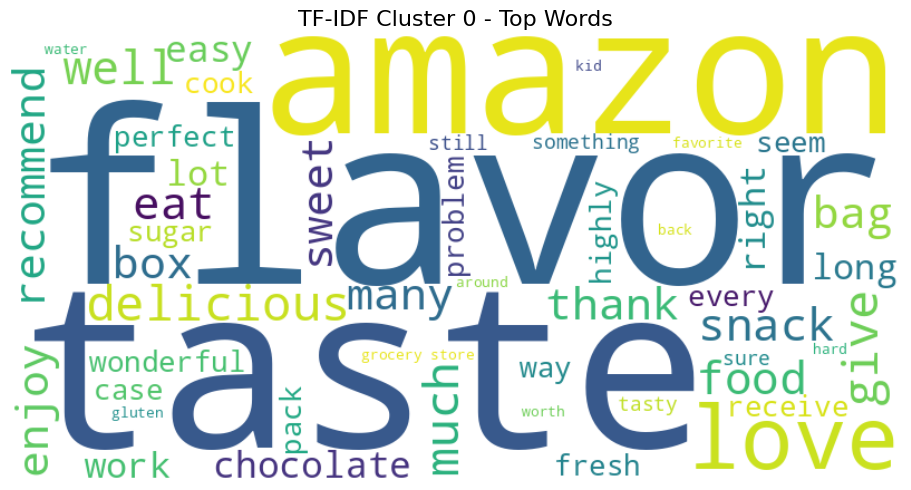


--- TF-IDF Кластер 1 ---
Размер: 2380 документов
Топ-15 слов: dog, treat, love, food, cat, eat, chew, pet, dry, try, recommend, chicken, vet, picky, healthy


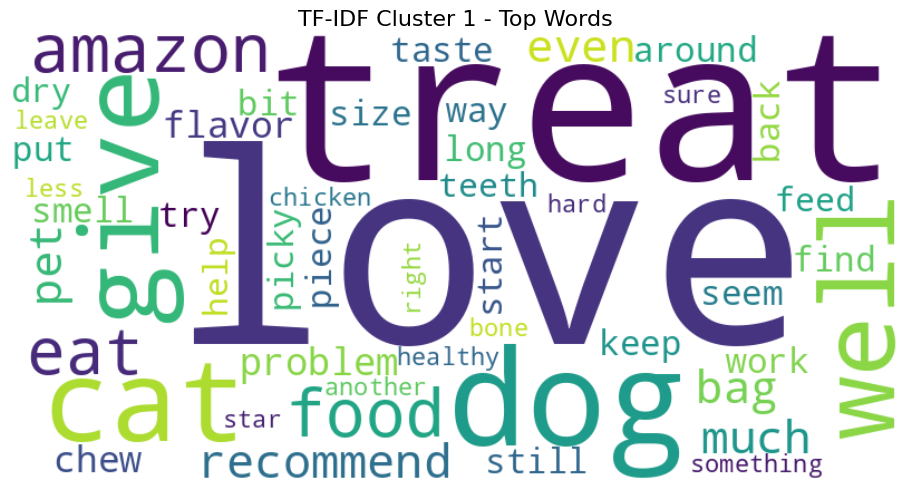


--- TF-IDF Кластер 2 ---
Размер: 4433 документов
Топ-15 слов: coffee, tea, cup, taste, flavor, drink, try, strong, love, brew, favorite, water, green, smooth, enjoy


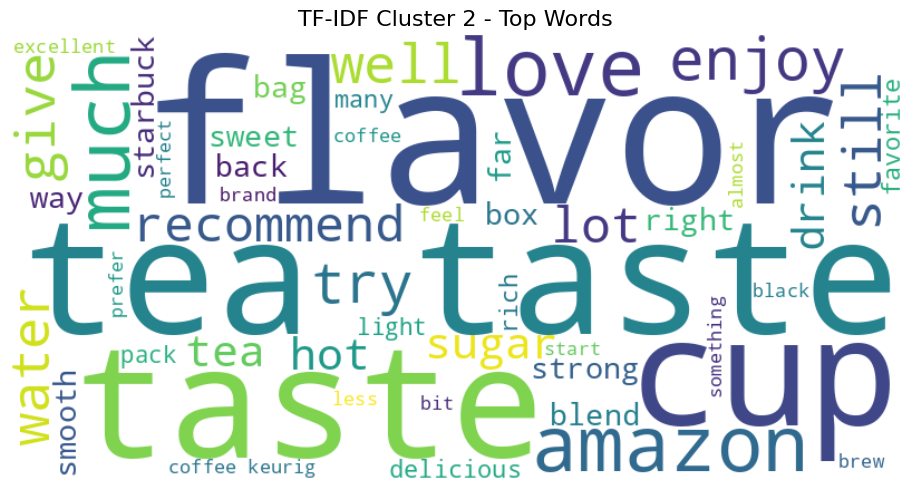

In [ ]:
# Анализ кластеров
unique_clusters = sorted(df_new['TFIDF_Cluster'].unique())

for cluster_id in unique_clusters:
    cluster_texts = df_new[df_new['TFIDF_Cluster'] == cluster_id]['processed_text']

    print(f"\n--- TF-IDF Кластер {cluster_id} ---")
    print(f"Размер: {len(cluster_texts)} документов")

    top_terms = get_tfidf_cluster_terms(cluster_id, n_terms=15)
    print(f"Топ-15 слов: {', '.join(top_terms)}")

    generate_wordcloud(cluster_texts, f'TF-IDF Cluster {cluster_id} - Top Words', max_words=50)

## **Кластер 1: Общие продукты питания и снеки**
- Гипотеза: широкий спектр пищевых продуктов, закусок и всяких сладостей
- Ключевые слова: taste, love, flavor, eat, try, amazon, store, snack, delicious, chocolate, food, sweet, bag, box, chip

*Анализ:*

1. Акцент на вкусовых характеристиках (taste, flavor, delicious, sweet)
2. Снеки и кондитерские изделия (chocolate, chip, snack)
3. Каналы продаж: Amazon и обычные магазины (store)
4. Упаковка: bag, box
5. Субъективные оценки, опыт: love, try, eat

## **Кластер 2: Корма и товары для домашних животных**
- Гипотеза: специализированные продукты для собак и кошек
- Ключевые слова: dog, treat, love, food, cat, eat, chew, pet, dry, try, recommend, chicken, vet, picky, healthy

*Анализ:*

1. Два основных типа животных: dogs и cats
2. Типы продуктов: лакомства (treat), корм (food), жевательные игрушки (chew)
3. Здоровье и рекомендации: vet (ветеринар), healthy, recommend
4. Особенности питания: picky (привередливые), dry (сухой корм)
5. Ингредиенты: chicken (курица) - популярный компонент для кормов питомцев

## **Кластер 3: Напитки - кофе и чай8**
- Гипотеза: горячие напитки, преимущественно кофе и различные виды чая
- Ключевые слова: coffee, tea, cup, taste, flavor, drink, try, strong, love, brew, favorite, water, green, smooth, enjoy

*Анализ:*

1. Два основных напитка: coffee и tea (включая зеленый - green)

2. Процесс приготовления: brew (заваривание), water

3. Характеристики напитков: strong (крепкий), smooth (мягкий)

4. Порции: cup (чашка)

5. Субъективный опыт: favorite (любимый), enjoy (наслаждаться)

6. Дегустация: taste, flavor, try


--- SBERT Кластер 1 ---
Размер: 4829 документов
Ключевые слова: coffee, accupuncturist, varieties, shortbread, isle, overpay, chisel, phytonutrients, contraceptive, obnoxiously, yamamotoyama, calories, thankyou, yummmmmmmmmmmm, barcode, havent, viscosity, autoship, inconsistency, dizziness


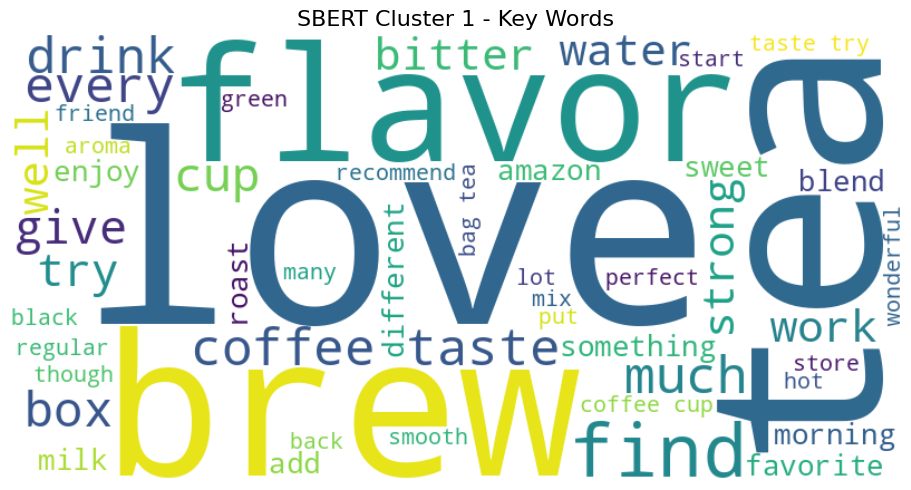


--- SBERT Кластер 2 ---
Размер: 2429 документов
Ключевые слова: dogfoods, varioustypes, digestibility, dentabites, overfishing, retriever, squirrelogs, unconditional, column, openind, lol, prednisolone, systembenefits, agreeable, bifidobacteria, elderly, perform, calorific, fee, symptoms


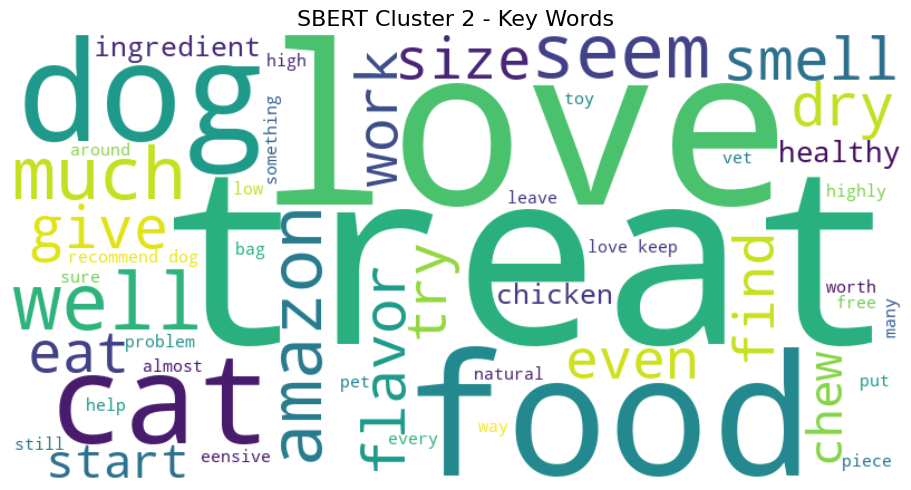


--- SBERT Кластер 3 ---
Размер: 9796 документов
Ключевые слова: flavorwise, graininess, celiacs, unpasteurized, dentures, optionalarmesan, tablespoon, agreedthat, qts, routine, gfcfsf, calories, antioxidant, sdescribed, camphor, bummer, webform, symptoms, educate, aberration


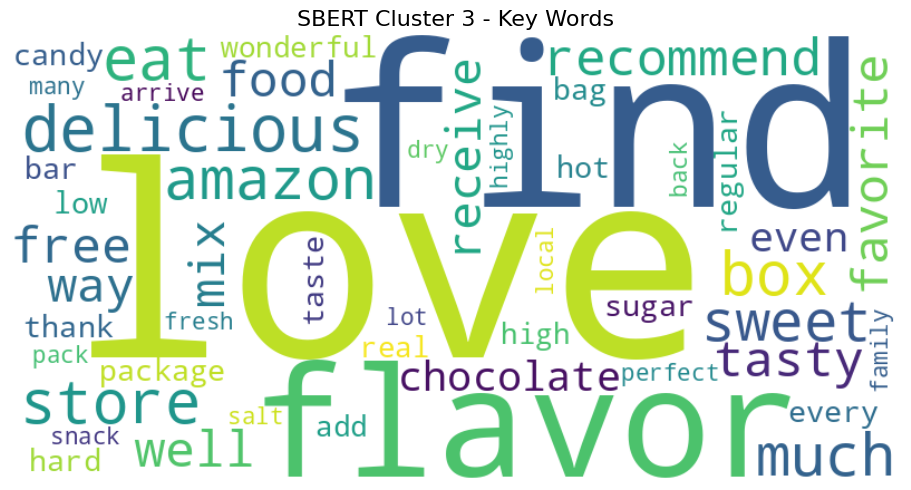

In [ ]:
# Анализ SBERT кластеров
for cluster_id in range(3):
    cluster_texts = df_new[df_new['SBERT_Cluster'] == cluster_id]['processed_text']

    print(f"\n--- SBERT Кластер {cluster_id} ---")
    print(f"Размер: {len(cluster_texts)} документов")

    # Ключевые слова через KeyBERT
    if len(cluster_texts) > 0:
        keywords = get_sbert_keywords(cluster_texts.tolist())
        print(f"Ключевые слова: {', '.join(keywords)}")

        generate_wordcloud(cluster_texts, f'SBERT Cluster {cluster_id} - Key Words')
    else:
        print("Пустой кластер")

## **Кластер 1: Тематические товары для здоровья и гурманов**
- Гипотеза темы: обсуждение специализированных продуктов питания, напитков и товаров для здоровья

Слова:
1. Ядро темы: coffee, shortbread, yamamotoyama (бренд чая), varieties (сорта), phytonutrients, calories, viscosity
2. Контекст и опыт: overpay (переплата), inconsistency (нестабильность качества), dizziness (головокружение), obnoxiously (раздражающе), acupuncturist (может указывать на контекст ЗОЖ)
3. Мета-информация: barcode, autoship (функция автоматической повторной доставки)
4. Тон отзывов: yummmmmmmmmmmm, thankyou, bummer (разочарование)

- Скорее всего, это отзывы покупателей специализированных на товары: кофе и чай премиум-сорта, полезное печенье (shortbread), добавки или продукты с фитонутриентами. Люди делятся впечатлениями от вкуса, текстуры (chisel - наверно, метафора твердости), эффекта, и возможно жалуются на несоответствие ожиданий
## **Кластер 2: Специализированные корма и здоровье домашних животных**
- Гипотеза темы: обсуждение кормов для собак, их ингредиентов, влияния на здоровье и пищеварение питомцев

Слова:
1. Ядро темы: dogfoods, dentabites (лакомства для зубов), retriever, squirrelogs (вид лакомства), digestibility, bifidobacteria, calorific (калорийность)
2. Здоровье и медицина: prednisolone (ветеринарный препарат), symptoms, elderly (пожилые собаки), systembenefits (польза для систем организма)
3. Контекст: overfishing (может касаться состава корма), unconditional (безусловная любовь к питомцу)
4. Тон: agreeable (подходящий), lol (неформальное общение)

- Отзывы на продукцию для питомцев, ветеринарные препараты. Обсуждаются конкретные бренды кормов (varioustypes), их влияние на пищеварение, специализированные корма для ретриверов, лекарства (преднизолон), а также лакомства для зубов

## **Кластер 3: Повседневная кулинария, продукты питания и личные впечатления**
- Гипотеза темы: широкий спектр обсуждений еды, готовки, диет и пищевых продуктов

Слова:
1. Ядро темы: flavorwise (что касается вкуса), graininess (зернистость), tablespoon (столовая ложка), qts (кварты - мера объема), routine (рутина, возможно, готовки), calories, antioxidant.
2. Диетические особенности: celiacs (для больных целиакией), unpasteurized (непастеризованный), gfcfsf (gluten-free/casein-free/soy-free - без глютена, казеина, сои)
3. Субъективные оценки и опыт: bummer, aberration (отклонение от нормы), agreedthat ("согласен, что..."), sdescribed ("как описано"), educate
4. Разное: dentures (зубные протезы - могут влиять на выбор пищи), camphor (камфора - может быть в описании вкуса/запаха)

- Это могут быть отзывы о еде и здоровом питании. Также люди делятся рецептами (с указанием мер), обсуждают текстуру продуктов, ищут варианты для специфических диет (безглютеновые, непастеризованные)